In [32]:
from keras import models, backend, datasets, utils
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, UpSampling2D, BatchNormalization, Concatenate
import matplotlib.pyplot as plt
import numpy as np

# UNET 모델링

In [26]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == "channels_last" else 1
    
        def conv(x, n_f, mp_flag = True):
            x = MaxPool2D((2, 2), padding = "same")(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x)
            x = Activation("tanh")(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x)
            x = Activation("tanh")(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis = ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x) # 과대적합 방지
            x = Activation("tanh")(x)
            x = Conv2D(n_f, (3, 3), padding = "same")(x)
            x = BatchNormalization()(x)
            x = Activation("tanh")(x)
            return x

        original = Input(shape = org_shape)
        # Encoding
        c1 = conv(original, 16, mp_flag = False)
        c2 = conv(c1, 32)

        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation = "sigmoid", padding = "same")(x)

        super().__init__(original, decoded)
        self.compile(optimizer = "adadelta", loss = "mse")

# 데이터 준비

In [27]:
class DATA():
    def __init__(self, in_ch = None): # in_ch = 학습에 사용할 채널, 흑백사진 = 채널을 1로 만들어야함
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        
        if x_train.ndim == 4:
            if backend.image_data_format() == "channels_first":
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
                
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
            
        in_ch = n_ch if in_ch is None else in_ch
        
        x_train = x_train.astype("float32")
        x_test = x_test.astype("float32")
        x_train /= 255
        x_test /= 255
        
        # 컬러 -> 흑백 변환 함수
        def RGB2Gray(X, fmt):
            if fmt == "channels_first":
                R = X[:, 0:1] # [0] = 0:1
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:
                R = X[..., 0:1] # ... 요거 이외의 모든 차원들
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        if backend.image_data_format() == "channels_first":
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_train.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
            
        else:
            x_train_out = x_train.reshape(x_train.shape[0],img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)
            
        # 그레이 스케일 변환 적용
        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
            
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out
            
        # 인스턴스 변수 변환
        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch

# 학습

In [28]:
data = DATA(in_ch = 1)

In [29]:
unet = UNET(data.input_shape, data.n_ch)

In [39]:
history = unet.fit(data.x_train_in, data.x_train_out,
                  epochs = 10,
                  batch_size = 128,
                  shuffle = True,
                  validation_split = 0.2)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - loss: 0.0284 - val_loss: 0.0271
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - loss: 0.0274 - val_loss: 0.0265
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 264ms/step - loss: 0.0267 - val_loss: 0.0259
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 238ms/step - loss: 0.0261 - val_loss: 0.0253
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - loss: 0.0257 - val_loss: 0.0248
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - loss: 0.0251 - val_loss: 0.0244
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 224ms/step - loss: 0.0247 - val_loss: 0.0239
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - loss: 0.0243 - val_loss: 0.0236
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - loss: 0.0239 - val_loss: 0.0232
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - loss: 0.0234 - val_loss: 0.0229


KeyError: 'test_loss'

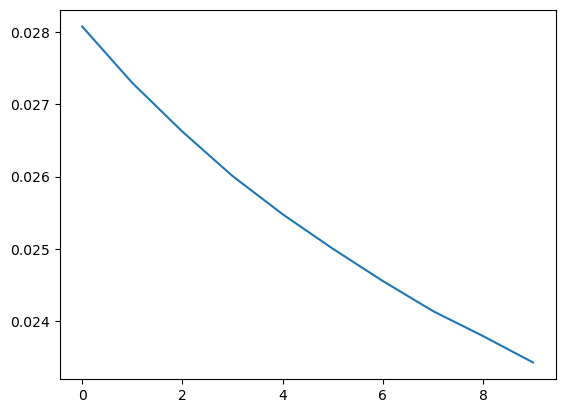

In [40]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["test_loss"], label = "test_loss")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [46]:
def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = unet.predict(x_test_in)
    
    if backend.image_data_format() == "channels_first":
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
            
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
            
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            
    else:
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
                          
    n = 10
    plt.figure(figsize = (20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1) # 입력
        plt.imshow(x_test_in[i], cmap = "gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
                          
        ax = plt.subplot(3, n, i + 1 + n) # 출력
        plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
         
        ax = plt.subplot(3, n, i + 1 + n * 2) # 정답값
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


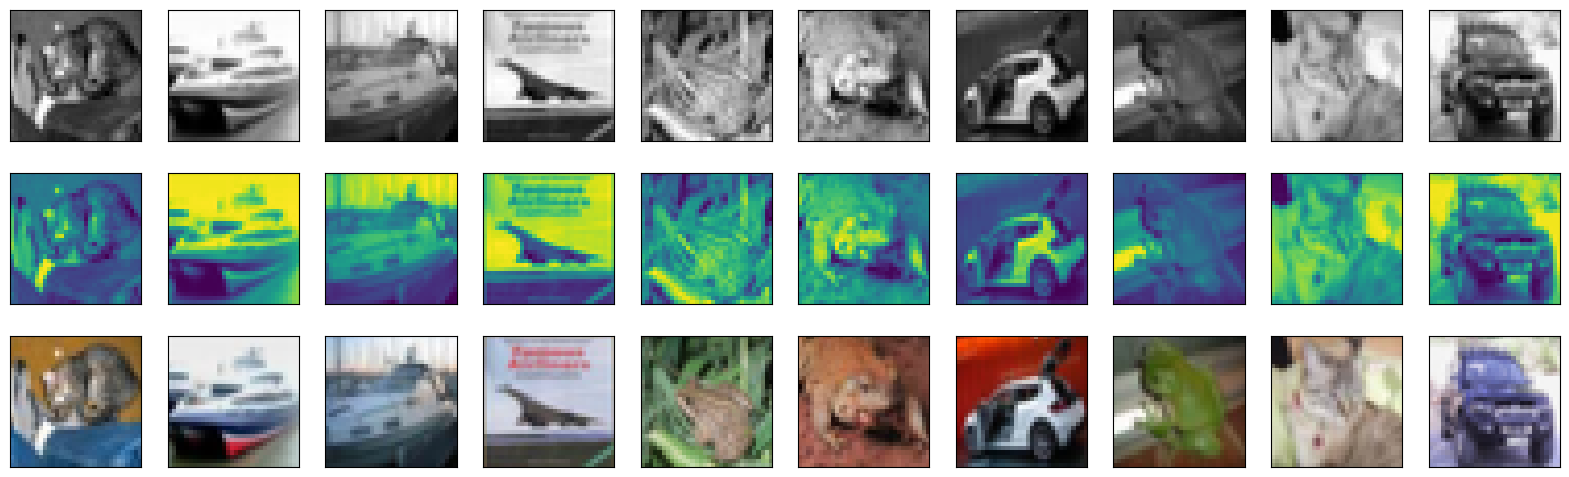

In [47]:
show_images(data, unet)